In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.interpolate
from pandas import DataFrame
from IPython.display import clear_output
from dtaidistance import dtw, dtw_visualisation as dtwvis, clustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib.pyplot import *
from scipy.spatial.distance import squareform
from skbio.stats.distance import DissimilarityMatrix
from sklearn.preprocessing import normalize
from sklearn import manifold
from matplotlib.lines import Line2D
import seaborn as sns
from os import listdir

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['draw_if_interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Production data import

In [2]:
path = 'HIST.txt'
df = pd.read_csv(path, delimiter = '\t')
print(len(df.WELL.unique()))
print(df.WELL.unique())
df.head()
#df.loc[df.WELL == 'WELL1A']

16
['WELL1' 'WELL10' 'WELL1A' 'WELL1B' 'WELL2' 'WELL2A' 'WELL3' 'WELL3A'
 'WELL4' 'WELL4A' 'WELL5' 'WELL5A' 'WELL6' 'WELL7' 'WELL8' 'WELL9']


,DATE,WELL,QOIL,QWAT,QGAS,BHP
0,2011-02-01,WELL1,7946.073372,34.680479,NaN,2236.946357
1,2011-03-04,WELL1,8196.885023,34.680479,NaN,2236.946357
2,2011-04-04,WELL1,7888.974902,34.680479,NaN,2236.946357
3,2011-05-05,WELL1,8040.342778,29.393044,NaN,2236.946357
4,2011-06-05,WELL1,8206.164825,9.307177,NaN,2236.946357


In [3]:
columns = list(df.columns.values)[2:]
wells = df.WELL.unique()

на 3 строке нужно всавлять соответствующую цифру для фильтрации дф по определенному параметру


In [4]:
temp_df = pd.DataFrame()
for i in wells:
    temp = df.loc[df.WELL == i].iloc[:, 2] # 2 QOIL, 3 QWAT, 4 QGAS, 5 BHP, 
    temp = temp.dropna()
    temp = temp.reset_index(drop = True)
    temp_df[i[4:]] = temp
temp_df = temp_df.fillna(0)
temp_df.head()

,1,10,1A,1B,2,2A,3,3A,4,4A,5,5A,6,7,8,9
0,7946.073372,6921.820804,8128.736957,7751.562887,6669.878461,6665.432892,8350.878569,7724.354569,8280.550662,8131.830260,8224.807453,7957.185856,8076.498701,8364.201055,8218.091506,6187.073777
1,8196.885023,7031.786463,7977.844973,8113.299721,6449.788560,6818.169559,8353.436638,7743.198648,7829.818046,8230.251332,7990.240978,7917.508379,7603.097992,8383.573446,8206.944065,6584.080705
2,7888.974902,6855.742893,7951.103058,7889.247859,6806.718405,6372.740506,7920.510933,8164.639354,8223.475231,8283.064223,7903.585950,8033.886950,8249.135106,7772.335530,7656.178470,6567.626397
3,8040.342778,6951.324528,7773.603514,7939.935350,6430.111241,6717.549615,8244.556709,8377.398510,7920.414343,8391.883093,7946.280304,8036.307143,8361.097520,7811.777401,7639.372592,6735.781471
4,8206.164825,7008.018640,8367.572056,8102.220248,6223.935618,6194.999314,8236.895827,7608.495940,7983.917399,7788.655852,7821.520657,8073.360619,8361.199849,8033.520968,7974.052639,6520.983647


Visulazation of clustermap

/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


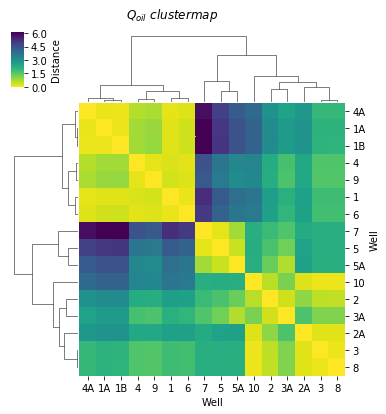

In [5]:
series = temp_df.T.as_matrix()
series /= np.atleast_2d(series.max(axis = 1)).T
distances = pdist(series, dtw.distance_fast)
a = pd.DataFrame(data = squareform(distances), index = temp_df.columns, columns = temp_df.columns)
cg = sns.clustermap(a, cmap = 'viridis_r', figsize=(6, 6))
cg.fig.suptitle(r'$Q_{oil}\ clustermap$')
plt.ylabel('Distance')
ax = cg.ax_heatmap
ax.set_xlabel('Well')
ax.set_ylabel('Well')
cg.fig.subplots_adjust(top = 0.92)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0);

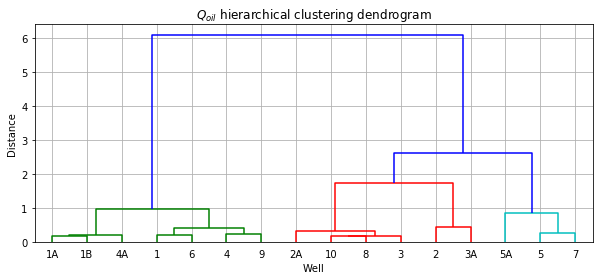

In [6]:
plt.figure(figsize = (10, 4))
links = linkage(distances, method = 'complete', metric = 'euclidean', optimal_ordering = True)
plt.title(r'$Q_{oil}$'+' hierarchical clustering dendrogram')
plt.xlabel('Well', fontsize = 10)
plt.ylabel('Distance')
dn = dendrogram(links, color_threshold = 2, leaf_font_size = 10, 
                labels = temp_df.columns, leaf_rotation = 0)
plt.grid()

0
[ 0 15  8 12  9  2  3]
['1', '9', '4', '6', '4A', '1A', '1B']
---
1
[ 4  1  5 14  7  6]
['2', '10', '2A', '8', '3A', '3']
---
2
[13 10 11]
['7', '5', '5A']
---


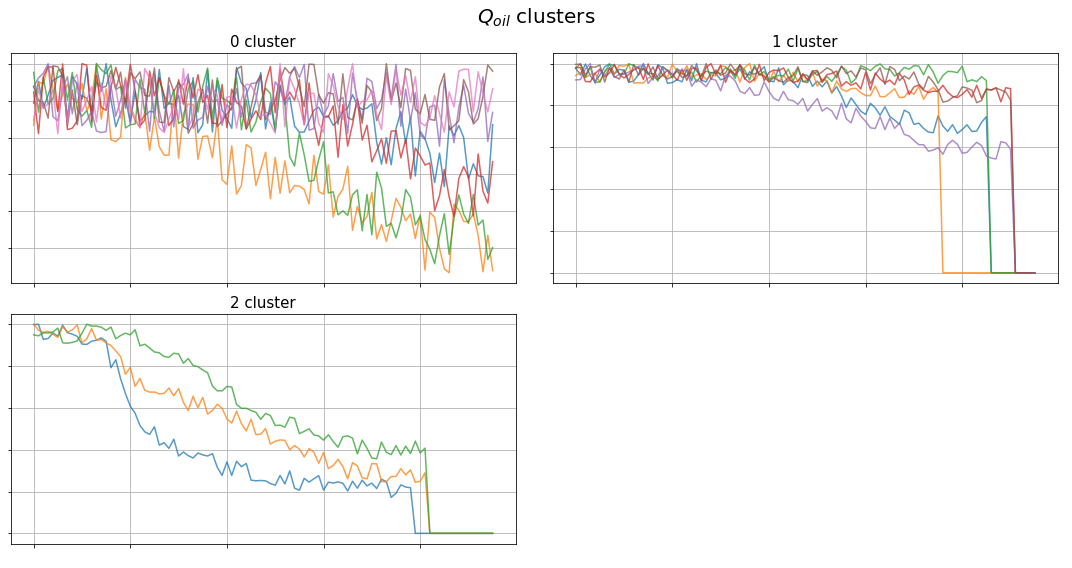

In [7]:
well_names_list = temp_df.columns
well_names_list = np.asarray(well_names_list)
final_well_list = []
final_cluster_list = []
def visualize_clusters(series, links, num_clusters, 
                       num_series_to_draw = 3,
                       draw_align = 'original',
                       make_gray = False):
    
    results = fcluster(links, num_clusters, criterion = 'maxclust')
    s = pd.Series(results)
    clusters = s.unique()
    ncols = 2
    nrows = np.ceil(len(clusters) / float(ncols)).astype(int)
    def get_series_to_plot(series, align = 'original'):
        if align == 'original':
            return series
        elif align == 'dtw':
            output_series = [series[0]]
            for i in range(1, len(series)):
                path = np.array(dtw.warping_path(series[0], series[i]))
                output_series.append(series[i, path[:, 1]])
            return output_series
        elif align == 'shift':
            output_series = [series[0]]
            for i in range(1, len(series)):
                path = np.array(dtw.warping_path(series[0], series[i]))
                path_diff = path[:, 0] - path[:, 1]
                counts, lefts = np.histogram(path_diff, bins = np.max(path_diff) - np.min(path_diff))
                left = -lefts[np.argmax(counts)].astype(int) 
                if left > 0:
                    output_series.append(series[i][left:])
                else:
                    output_series.append(np.hstack((np.zeros(-left), series[i])))
            return output_series
        else:
            raise ValueError('')
    count = 0
    f, axs = subplots(ncols = ncols, nrows = nrows, figsize = (15, 4 * nrows))
    for row in range(nrows):
        for col in range(ncols):
            ax = axs[row, col] if nrows > 1 else axs[col]
            cluster_idx = row * ncols + col
            if cluster_idx >= len(clusters):
                ax.axis('off')
                break
            print(count)
            cluster_indices = s[s == cluster_idx + 1].index
            num_series_to_select = min(num_series_to_draw, len(cluster_indices))
            cluster_indices = np.random.choice(cluster_indices, num_series_to_select, replace = False)
            print(cluster_indices)
            well_list = []
            for i in well_names_list[cluster_indices]:
                well_list.append(i)
            print(well_list)
            cluster_list = []
            for i in well_names_list[cluster_indices]:
                cluster_list.append(count)
            print('---')
            series_to_plot = get_series_to_plot(series[cluster_indices, :], 
                                                align = draw_align)
            plt.suptitle(r'$Q_{oil}$'+' clusters', fontsize = 20)
            for y in series_to_plot:
                if make_gray:
                    ax.plot(y, color = 'gray', alpha = 0.75)
                else:
                    ax.plot(y, alpha = 0.75)
                ax.set_title(str(count) + ' cluster', fontsize = 15)
                ax.get_xaxis().set_ticklabels([])
                ax.get_yaxis().set_ticklabels([])
            final_well_list.append(well_list)
            final_cluster_list.append(cluster_list)
            count += 1
            ax.grid(True)       
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
num_clusters = 3
num_series_to_draw = 100
draw_align = 'original'
make_gray = False
visualize_clusters(series, links, num_clusters, num_series_to_draw, draw_align, make_gray)

In [8]:
flattened_wells = [y for x in final_well_list for y in x]
flattened_clusters = [y for x in final_cluster_list for y in x]
wells_and_clusters = pd.DataFrame({'Well': flattened_wells, 'Cluster': flattened_clusters})
wells_and_clusters.to_pickle('Clusters/Qoil.pkl')
wells_and_clusters.head(20)

,Well,Cluster
0,1,0
1,9,0
2,4,0
3,6,0
4,4A,0
5,1A,0
6,1B,0
7,2,1
8,10,1
9,2A,1


## Data visualisation of obtained clusters

In [9]:
path = 'PRODUCTION DATA/OBS.xlsx'
df_hist = pd.read_excel(path)
print(df_hist.shape)
df_hist.head()

(96, 69)


,TIME,WBHP:WELL1,WBHP:WELL1A,WBHP:WELL1B,WBHP:WELL9,WBHP:WELL4,WBHP:WELL4A,WBHP:WELL6,WBHP:WELL8,WBHP:WELL3,...,WGPR:WELL6,WGPR:WELL8,WGPR:WELL3,WGPR:WELL3A,WGPR:WELL2,WGPR:WELL2A,WGPR:WELL5,WGPR:WELL5A,WGPR:WELL7,WGPR:WELL10
0,31,2236.946357,2056.431104,2166.392038,2398.164917,2099.967864,2092.965638,2161.395775,NaN,NaN,...,2678.222242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2902.789375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2813.077959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2871.503929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2787.114345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
header = df_hist.columns.values
print(header[:1]) # ['TIME']
print(header[1:17]) # WBHP
print(header[17:33]) # WOPR
print(header[33:49]) # WWPR
print(header[55:]) # WGPR

['TIME']
['WBHP:WELL1' 'WBHP:WELL1A' 'WBHP:WELL1B' 'WBHP:WELL9' 'WBHP:WELL4'
 'WBHP:WELL4A' 'WBHP:WELL6' 'WBHP:WELL8' 'WBHP:WELL3' 'WBHP:WELL3A'
 'WBHP:WELL2' 'WBHP:WELL2A' 'WBHP:WELL5' 'WBHP:WELL5A' 'WBHP:WELL7'
 'WBHP:WELL10']
['WOPR:WELL1' 'WOPR:WELL1A' 'WOPR:WELL1B' 'WOPR:WELL9' 'WOPR:WELL4'
 'WOPR:WELL4A' 'WOPR:WELL6' 'WOPR:WELL8' 'WOPR:WELL3' 'WOPR:WELL3A'
 'WOPR:WELL2' 'WOPR:WELL2A' 'WOPR:WELL5' 'WOPR:WELL5A' 'WOPR:WELL7'
 'WOPR:WELL10']
['WWPR:WELL1' 'WWPR:WELL1A' 'WWPR:WELL1B' 'WWPR:WELL9' 'WWPR:WELL4'
 'WWPR:WELL4A' 'WWPR:WELL6' 'WWPR:WELL8' 'WWPR:WELL3' 'WWPR:WELL3A'
 'WWPR:WELL2' 'WWPR:WELL2A' 'WWPR:WELL5' 'WWPR:WELL5A' 'WWPR:WELL7'
 'WWPR:WELL10']
['WGPR:WELL1B' 'WGPR:WELL9' 'WGPR:WELL4' 'WGPR:WELL4A' 'WGPR:WELL6'
 'WGPR:WELL8' 'WGPR:WELL3' 'WGPR:WELL3A' 'WGPR:WELL2' 'WGPR:WELL2A'
 'WGPR:WELL5' 'WGPR:WELL5A' 'WGPR:WELL7' 'WGPR:WELL10']


## Production data vizualization

In [11]:
customPalette = ['green',  '#39C8C6', 'red', '#630C3A', 'Orange', '#3498DB', 'Tomato', 'Violet', "#9B59B6", 
                 "#3498DB", "Coral", "#E74C3C", "Brown", "Goldenrod", '#630C3A', '#39C8C6', 
                 'Orange', '#3498DB', 'Tomato', 'Violet', "#9B59B6", "#3498DB", "Coral", 
                 "#E74C3C", "Brown", "Goldenrod"]

In [12]:
def plot(x, y, xmin, xmax, xstep, ymin, ymax, ystep, xlabel, ylabel, fontsize, **kwargs):
    plt.plot(x, y, **kwargs)
    plt.grid(True)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xticks(np.arange(xmin, xmax, xstep))
    plt.yticks(np.arange(ymin, ymax, ystep))

WOPR

In [13]:
ymin = 0
ymax = 10000
ystep = 2000
xmin = 0
xmax = 3000
xstep = 500
xlabel = 'Days' 
ylabel = 'WOPR, STB/day'
fontsize = 10

In [14]:
print(header[17:33])
wells = list(wells_and_clusters.Well.values)
clusters = list(wells_and_clusters.Cluster.values)
print(wells)
print(clusters)
clusters = np.array(clusters)
well_names = []
additional = 'WOPR:WELL'
for j in np.unique(clusters):
    sublist = []
    for i in range(len(clusters)):
        if clusters[i] == j:
            temp = additional + wells[i]
            sublist.append(temp)
    well_names.append(sublist)    
print(well_names)
variable = 'profiles_WOPR_1'

['WOPR:WELL1' 'WOPR:WELL1A' 'WOPR:WELL1B' 'WOPR:WELL9' 'WOPR:WELL4'
 'WOPR:WELL4A' 'WOPR:WELL6' 'WOPR:WELL8' 'WOPR:WELL3' 'WOPR:WELL3A'
 'WOPR:WELL2' 'WOPR:WELL2A' 'WOPR:WELL5' 'WOPR:WELL5A' 'WOPR:WELL7'
 'WOPR:WELL10']
['1', '9', '4', '6', '4A', '1A', '1B', '2', '10', '2A', '8', '3A', '3', '7', '5', '5A']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
[['WOPR:WELL1', 'WOPR:WELL9', 'WOPR:WELL4', 'WOPR:WELL6', 'WOPR:WELL4A', 'WOPR:WELL1A', 'WOPR:WELL1B'], ['WOPR:WELL2', 'WOPR:WELL10', 'WOPR:WELL2A', 'WOPR:WELL8', 'WOPR:WELL3A', 'WOPR:WELL3'], ['WOPR:WELL7', 'WOPR:WELL5', 'WOPR:WELL5A']]


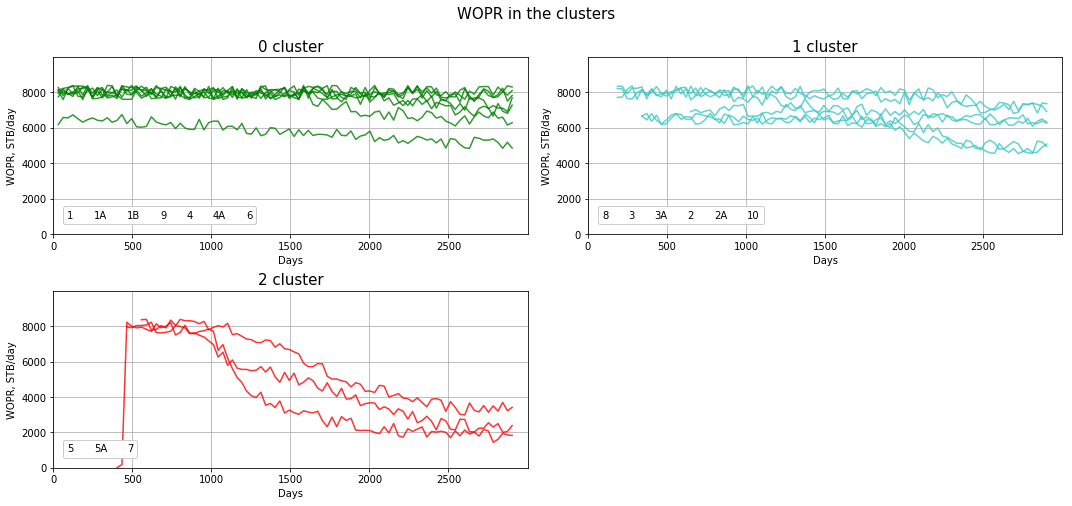

In [15]:
plt.figure(figsize = (15, 10))
plt.suptitle('WOPR in the clusters', fontsize = fontsize + 5)
nrows = 3
ncols = 2
index = 1 
for j in range(len(np.unique(clusters))):
    plt.subplot(nrows, ncols, index)
    plt.title(str(j) + ' cluster', fontsize = fontsize + 5)
    for i in header[17:33]:
        if i in well_names[j]:
            temp = df_hist.filter(items = [i, 'TIME']).dropna()
            plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel,  alpha = 0.8, color = customPalette[j], label = i[9:],
                fontsize = fontsize)
    index += 1
    legend = plt.legend(loc = 'lower left', ncol = 10, 
                        borderaxespad = 1, shadow = False, fontsize = fontsize, 
                        frameon = True, fancybox = True, framealpha = 1,  
                        handletextpad = 0, handlelength = 0)
    legend.get_frame()
plt.tight_layout()
plt.subplots_adjust(top = 0.91)

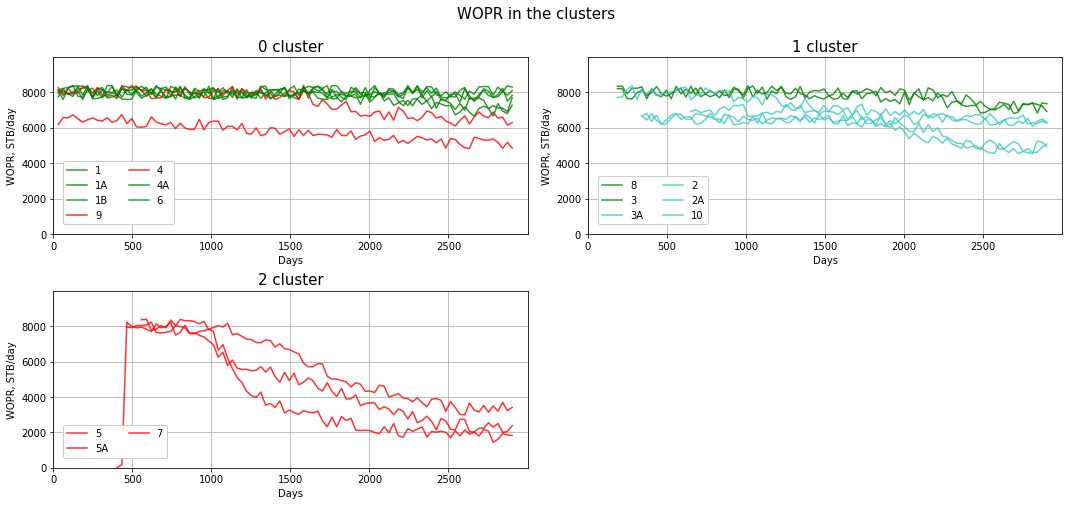

In [16]:
# отметил тут скважины которые перенес в другой кластер
plt.figure(figsize = (15, 10))
plt.suptitle('WOPR in the clusters', fontsize = fontsize + 5)
nrows = 3
ncols = 2
index = 1 
for j in range(len(np.unique(clusters))):
    plt.subplot(nrows, ncols, index)
    plt.title(str(j) + ' cluster', fontsize = fontsize + 5)
    for i in header[17:33]: 
        if i in well_names[j]:
            temp = df_hist.filter(items = [i, 'TIME']).dropna()
            if i == 'WOPR:WELL9':
                 plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel,  alpha = 0.8, color = customPalette[2], label = i[9:],fontsize = fontsize)
            elif i == 'WOPR:WELL4':
                 plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel,  alpha = 0.8, color = customPalette[2], label = i[9:],fontsize = fontsize)
            elif i == 'WOPR:WELL8':
                 plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel,  alpha = 0.8, color = customPalette[0], label = i[9:],fontsize = fontsize)
            elif i == 'WOPR:WELL3':
                 plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                    ylabel = ylabel,  alpha = 0.8, color = customPalette[0], label = i[9:], fontsize = fontsize)
            else: plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel,  alpha = 0.8, color = customPalette[j], label = i[9:], fontsize = fontsize)
    index += 1
    legend = plt.legend(loc = 'lower left', ncol = 2, 
                        borderaxespad = 1, shadow = False, fontsize = fontsize, 
                        frameon = True, fancybox = True, framealpha = 1)
    legend.get_frame();
plt.tight_layout()
plt.subplots_adjust(top = 0.91)

WBHP

In [17]:
ymin = 1500
ymax = 2700
ystep = 250
xmin = 0
xmax = 3000
xstep = 500
xlabel = 'Days' 
ylabel = 'WBHP, psia'
fontsize = 10

In [18]:
print(header[1:17])
wells = list(wells_and_clusters.Well.values)
clusters = list(wells_and_clusters.Cluster.values)
print(wells)
print(clusters)
clusters = np.array(clusters)
well_names = []
additional = 'WBHP:WELL'
for j in np.unique(clusters):
    sublist = []
    for i in range(len(clusters)):
        if clusters[i] == j:
            temp = additional + wells[i]
            sublist.append(temp)
    well_names.append(sublist)    
print(well_names)
variable = 'profiles_BHP_1'

['WBHP:WELL1' 'WBHP:WELL1A' 'WBHP:WELL1B' 'WBHP:WELL9' 'WBHP:WELL4'
 'WBHP:WELL4A' 'WBHP:WELL6' 'WBHP:WELL8' 'WBHP:WELL3' 'WBHP:WELL3A'
 'WBHP:WELL2' 'WBHP:WELL2A' 'WBHP:WELL5' 'WBHP:WELL5A' 'WBHP:WELL7'
 'WBHP:WELL10']
['1', '9', '4', '6', '4A', '1A', '1B', '2', '10', '2A', '8', '3A', '3', '7', '5', '5A']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
[['WBHP:WELL1', 'WBHP:WELL9', 'WBHP:WELL4', 'WBHP:WELL6', 'WBHP:WELL4A', 'WBHP:WELL1A', 'WBHP:WELL1B'], ['WBHP:WELL2', 'WBHP:WELL10', 'WBHP:WELL2A', 'WBHP:WELL8', 'WBHP:WELL3A', 'WBHP:WELL3'], ['WBHP:WELL7', 'WBHP:WELL5', 'WBHP:WELL5A']]


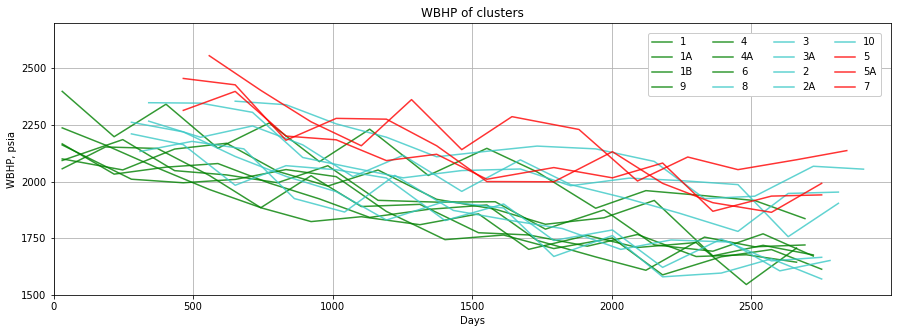

In [19]:
plt.figure(figsize = (15, 5))
plt.title('WBHP of clusters')
yaxis = True
for j in range(len(np.unique(clusters))):
    for i in header[1:17]: # WBHP columns
        if i in well_names[j]:
            temp = df_hist.filter(items = [i, 'TIME']).dropna()
            plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel, color = customPalette[j], alpha = 0.8, label = i[9:],
                fontsize = fontsize)
legend = plt.legend(loc = 'upper right', ncol = 4, 
                        borderaxespad = 1, shadow = False, fontsize = fontsize, 
                        frameon = True, fancybox = True, framealpha = 1)
legend.get_frame();

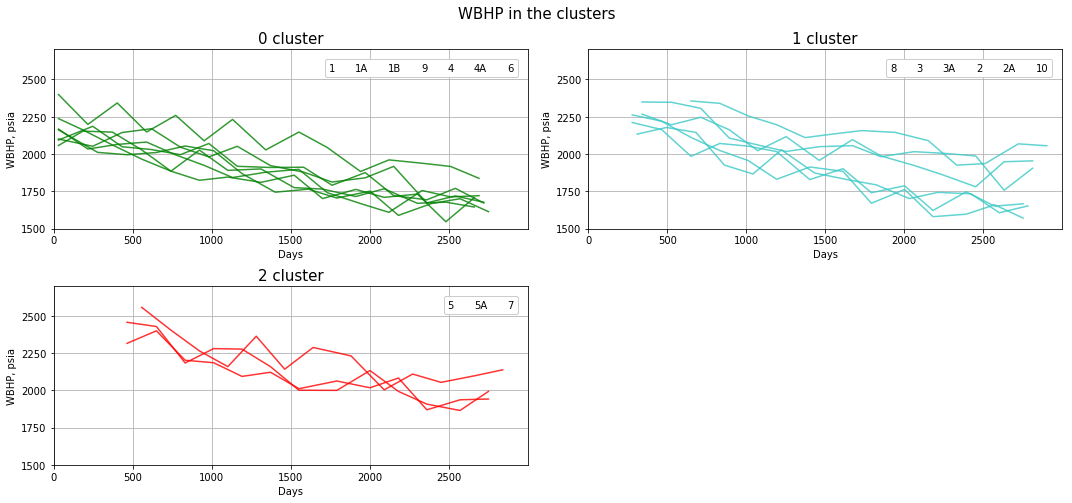

In [20]:
plt.figure(figsize = (15, 10))
plt.suptitle('WBHP in the clusters', fontsize = fontsize + 5)
nrows = 3
ncols = 2
index = 1 
for j in range(len(np.unique(clusters))):
    plt.subplot(nrows, ncols, index)
    plt.title(str(j) + ' cluster', fontsize = fontsize + 5)
    for i in header[1:17]:
        if i in well_names[j]:
            temp = df_hist.filter(items = [i, 'TIME']).dropna()
            plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel,  alpha = 0.8, label = i[9:], color = customPalette[j],
                fontsize = fontsize)
    index += 1
    legend = plt.legend(loc = 'upper right', ncol = 10, 
                        borderaxespad = 1, shadow = False, fontsize = fontsize, 
                        frameon = True, fancybox = True, framealpha = 1,  
                        handletextpad = 0, handlelength = 0)
    legend.get_frame()
plt.tight_layout()
plt.subplots_adjust(top = 0.92)

WWPR

In [21]:
ymin = 0
ymax = 7000
ystep = 2000
xmin = 0
xmax = 3000
xstep = 500
xlabel = 'Days' 
ylabel = 'WWPR, STB/day'
fontsize = 10

In [22]:
print(header[33:49])
wells = list(wells_and_clusters.Well.values)
clusters = list(wells_and_clusters.Cluster.values)
print(wells)
print(clusters)
clusters = np.array(clusters)
well_names = []
additional = 'WWPR:WELL'
for j in np.unique(clusters):
    sublist = []
    for i in range(len(clusters)):
        if clusters[i] == j:
            temp = additional + wells[i]
            sublist.append(temp)
    well_names.append(sublist)    
print(well_names)
variable = 'profiles_WWPR_1'

['WWPR:WELL1' 'WWPR:WELL1A' 'WWPR:WELL1B' 'WWPR:WELL9' 'WWPR:WELL4'
 'WWPR:WELL4A' 'WWPR:WELL6' 'WWPR:WELL8' 'WWPR:WELL3' 'WWPR:WELL3A'
 'WWPR:WELL2' 'WWPR:WELL2A' 'WWPR:WELL5' 'WWPR:WELL5A' 'WWPR:WELL7'
 'WWPR:WELL10']
['1', '9', '4', '6', '4A', '1A', '1B', '2', '10', '2A', '8', '3A', '3', '7', '5', '5A']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
[['WWPR:WELL1', 'WWPR:WELL9', 'WWPR:WELL4', 'WWPR:WELL6', 'WWPR:WELL4A', 'WWPR:WELL1A', 'WWPR:WELL1B'], ['WWPR:WELL2', 'WWPR:WELL10', 'WWPR:WELL2A', 'WWPR:WELL8', 'WWPR:WELL3A', 'WWPR:WELL3'], ['WWPR:WELL7', 'WWPR:WELL5', 'WWPR:WELL5A']]


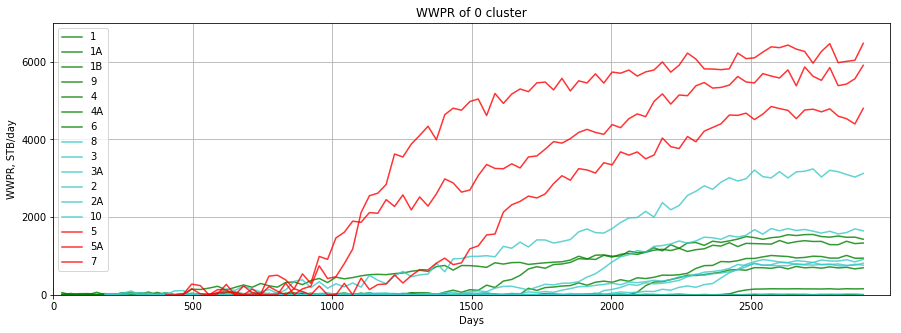

In [23]:
plt.figure(figsize = (15, 5))
plt.title('WWPR of 0 cluster')
yaxis = True
for j in range(len(np.unique(clusters))):
    for i in header[33:49]:
        if i in well_names[j]:
            temp = df_hist.filter(items = [i, 'TIME']).dropna()
            plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel, color = customPalette[j], alpha = 0.8, label = i[9:],
                  fontsize = fontsize)
legend = plt.legend(loc = 'upper left', shadow = False, fontsize = 'medium')
legend.get_frame();

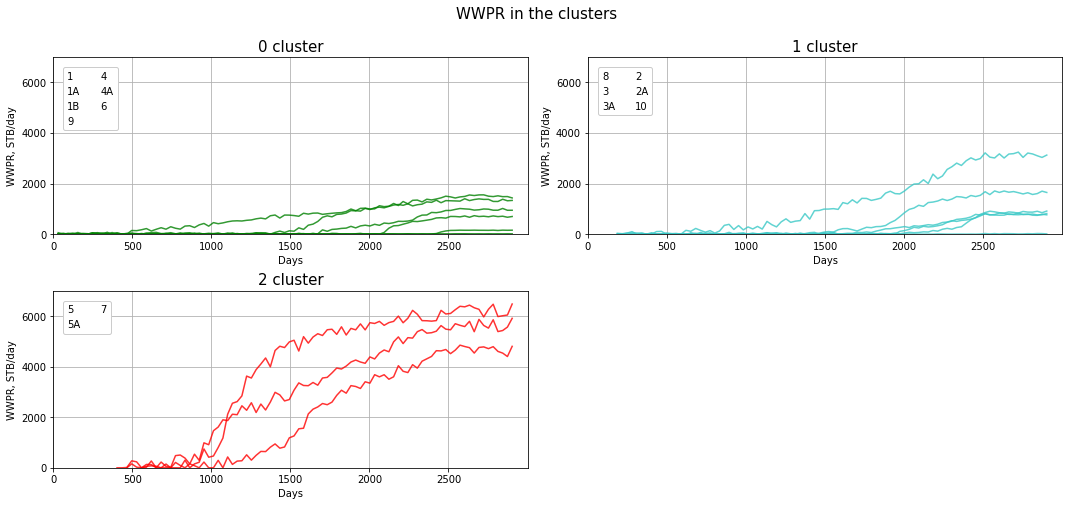

In [24]:
plt.figure(figsize = (15, 10))
plt.suptitle('WWPR in the clusters', fontsize = fontsize + 5)
nrows = 3
ncols = 2
index = 1 
for j in range(len(np.unique(clusters))):
    plt.subplot(nrows, ncols, index)
    plt.title(str(j) + ' cluster', fontsize = fontsize + 5)
    for i in header[33:49]:
        if i in well_names[j]:
            temp = df_hist.filter(items = [i, 'TIME']).dropna()
            plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel,  alpha = 0.8, label = i[9:], color = customPalette[j],
                fontsize = fontsize)
    index += 1
    legend = plt.legend(loc = 'upper left', ncol = 2, 
                        borderaxespad = 1, shadow = False, fontsize = fontsize, 
                        frameon = True, fancybox = True, framealpha = 1,  
                        handletextpad = 0, handlelength = 0)
    legend.get_frame();
plt.tight_layout()
plt.subplots_adjust(top = 0.91)

WGPR

In [25]:
ymin = 0
ymax = 3500
ystep = 1000
xmin = 0
xmax = 3000
xstep = 500
xlabel = 'Days' 
ylabel = 'WGPR, STB/day'

In [26]:
print(header[55:])
wells = list(wells_and_clusters.Well.values)
clusters = list(wells_and_clusters.Cluster.values)
print(wells)
print(clusters)
clusters = np.array(clusters)
well_names = []
additional = 'WGPR:WELL'
for j in np.unique(clusters):
    sublist = []
    for i in range(len(clusters)):
        if clusters[i] == j:
            temp = additional + wells[i]
            sublist.append(temp)
    well_names.append(sublist)    
print(well_names)

['WGPR:WELL1B' 'WGPR:WELL9' 'WGPR:WELL4' 'WGPR:WELL4A' 'WGPR:WELL6'
 'WGPR:WELL8' 'WGPR:WELL3' 'WGPR:WELL3A' 'WGPR:WELL2' 'WGPR:WELL2A'
 'WGPR:WELL5' 'WGPR:WELL5A' 'WGPR:WELL7' 'WGPR:WELL10']
['1', '9', '4', '6', '4A', '1A', '1B', '2', '10', '2A', '8', '3A', '3', '7', '5', '5A']
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
[['WGPR:WELL1', 'WGPR:WELL9', 'WGPR:WELL4', 'WGPR:WELL6', 'WGPR:WELL4A', 'WGPR:WELL1A', 'WGPR:WELL1B'], ['WGPR:WELL2', 'WGPR:WELL10', 'WGPR:WELL2A', 'WGPR:WELL8', 'WGPR:WELL3A', 'WGPR:WELL3'], ['WGPR:WELL7', 'WGPR:WELL5', 'WGPR:WELL5A']]


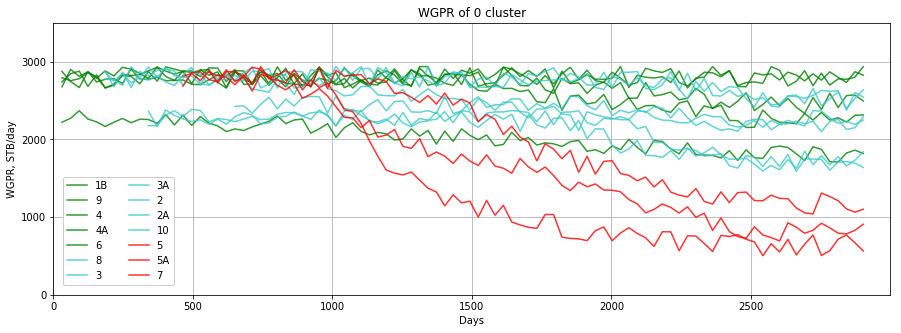

In [27]:
plt.figure(figsize = (15, 5))
plt.title('WGPR of 0 cluster')
for j in range(len(np.unique(clusters))):
    for i in header[55:]: # WBHP columns
        if i in well_names[j]:
            temp = df_hist.filter(items = [i, 'TIME']).dropna()
            plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel, color = customPalette[j], alpha = 0.8, label = i[9:],
                fontsize = fontsize)
            
legend = plt.legend(loc = 'lower left', ncol = 2, borderaxespad = 1, shadow = False, 
                    fontsize = fontsize, frameon = True, fancybox = True, framealpha = 1)

legend.get_frame();

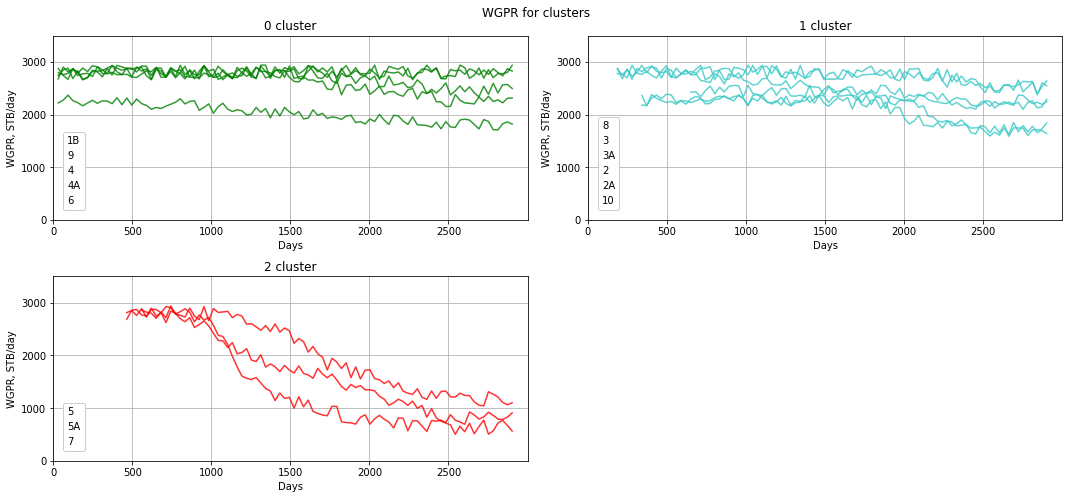

In [28]:
plt.figure(figsize = (15, 10))
plt.suptitle('WGPR for clusters')
nrows = 3
ncols = 2
index = 1 
for j in range(len(np.unique(clusters))):
    plt.subplot(nrows, ncols, index)
    plt.title(str(j) + ' cluster')
    for i in header[55:]: 
        if i in well_names[j]:
            temp = df_hist.filter(items = [i, 'TIME']).dropna()
            plot(x = temp.iloc[:, 1:2], y = temp.iloc[:, 0:1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel,  alpha = 0.8, label = i[9:], color = customPalette[j],
                fontsize = fontsize)
    index += 1
    legend = plt.legend(loc = 'lower left', ncol = 1, borderaxespad = 1, shadow = False, 
    fontsize = fontsize, frameon = True, fancybox = True, framealpha = 1,  
                        handletextpad = 0, handlelength = 0)
    legend.get_frame();
plt.tight_layout()
plt.subplots_adjust(top = 0.94)